In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [2]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [3]:
%%bash
pip install pytorch-pretrained-bert

You are using pip version 19.0.3, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=256,
)

In [5]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

100%|██████████| 231508/231508 [00:00<00:00, 1994456.13B/s]


In [6]:
def _join_texts(texts:Collection[str], mark_fields:bool=False, sos_token:Optional[str]=BOS):
    """Borrowed from fast.ai source"""
    if not isinstance(texts, np.ndarray): texts = np.array(texts)
    if is1d(texts): texts = texts[:,None]
    df = pd.DataFrame({i:texts[:,i] for i in range(texts.shape[1])})
    text_col = f'{FLD} {1} ' + df[0].astype(str) if mark_fields else df[0].astype(str)
    if sos_token is not None: text_col = f"{sos_token} " + text_col
    for i in range(1,len(df.columns)):
        #text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i]
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i].astype(str)
    return text_col.values

In [7]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [48]:
from sklearn.model_selection import train_test_split

In [62]:
raw_train = pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/train.csv',index_col='ID')
raw_test = pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/test.csv',index_col='ID')

In [63]:
raw_train['text'] = raw_train['TITLE'].astype(str) + '. ' + raw_train['ABSTRACT'].astype(str)
raw_test['text'] = raw_test['TITLE'].astype(str) + '. ' + raw_test['ABSTRACT'].astype(str)

In [64]:
raw_train.drop(['TITLE','ABSTRACT'],axis=1,inplace=True)
raw_test.drop(['TITLE','ABSTRACT'],axis=1,inplace=True)

In [65]:
train, val = train_test_split(raw_train,test_size=0.2,random_state=2020)

In [66]:
test = raw_test

In [68]:
train = train[['text','Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']]
val = val[['text','Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']]

In [72]:
train.head(1)

,text,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,
20301,The interplay between Steinberg algebras and p...,0,0,1,0,0,0


In [ ]:
test.head(1)

In [71]:
val.head(1)

,text,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,
134,Representing numbers as the sum of squares and...,0,0,1,0,0,0


In [21]:
# train = pd.read_csv('../input/av-janatahack-nlp-topic-classification/data/train.csv',index_col='id')
# val = pd.read_csv('../input/av-janatahack-nlp-topic-classification/data/val.csv',index_col='id')
# test = pd.read_csv('../input/av-janatahack-nlp-topic-classification/data/test.csv',index_col='id')

In [22]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In [23]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [24]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [25]:
train.columns

Index(['text', 'Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [26]:
label_cols = ['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']

# databunch = TextDataBunch.from_df(".", train, val, test,
#                   tokenizer=fastai_tokenizer,
#                   vocab=fastai_bert_vocab,
#                   include_bos=False,
#                   include_eos=False,
#                   text_cols="comment_text",
#                   label_cols=label_cols,
#                   bs=config.bs,
#                   collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
#              )

Alternatively, we can pass our own list of Preprocessors to the databunch (this is effectively what is happening behind the scenes)

In [27]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [29]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [31]:
# this will produce a virtually identical databunch to the code above
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

# Model

In [32]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=6)

100%|██████████| 407873900/407873900 [00:08<00:00, 45510277.69B/s]


In [33]:
loss_func = nn.BCEWithLogitsLoss()

In [34]:
from fastai.callbacks import *

learner = Learner(
    databunch, bert_model,
    loss_func=loss_func,
)
if config.use_fp16: learner = learner.to_fp16()

In [35]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


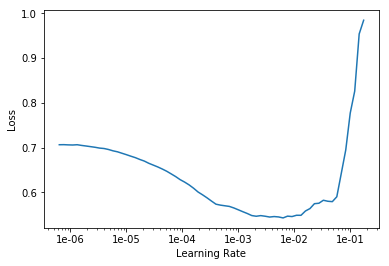

In [36]:
learner.recorder.plot()

In [38]:
print(config.max_lr)

3e-05


In [37]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,time
0,0.222288,0.204738,07:21
1,0.170824,0.173040,07:21
2,0.131171,0.164681,07:23
3,0.113668,0.168109,07:23


In [39]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [40]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [41]:
sample_submission = pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/sample_submission_UVKGLZE.csv')
if config.testing: sample_submission = sample_submission.head(test.shape[0])
sample_submission[label_cols] = test_preds

In [44]:
sample_submission.set_index('ID',inplace=True)

In [45]:
sample_submission[sample_submission>=0.45]=int(1)
sample_submission[sample_submission<0.45]=int(0)

In [46]:
sample_submission.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,
20973,1.0,0.0,0.0,1.0,0.0,0.0
20974,0.0,1.0,0.0,0.0,0.0,0.0
20975,1.0,0.0,0.0,0.0,0.0,0.0
20976,0.0,1.0,0.0,0.0,0.0,0.0
20977,1.0,0.0,0.0,0.0,0.0,0.0


In [47]:
sample_submission.to_csv("BERT_submissions_v2.csv")